In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import (make_blobs, make_circles, make_moons)
import pickle
from scipy.ndimage import label
from sklearn.preprocessing import MinMaxScaler
from utils import *

In [2]:
def gaussian(x, y, x0, y0, sigma=1):
    return np.exp(-((x - x0)**2 + (y - y0)**2) / (2 * sigma**2))

In [3]:
data = make_circles(factor=0.5, noise=0.05, n_samples=500)[0]
scaler = MinMaxScaler(feature_range=(0, 1))
if len(data.shape) == 1:
    data = data.reshape(-1, 1)
data = scaler.fit_transform(data)

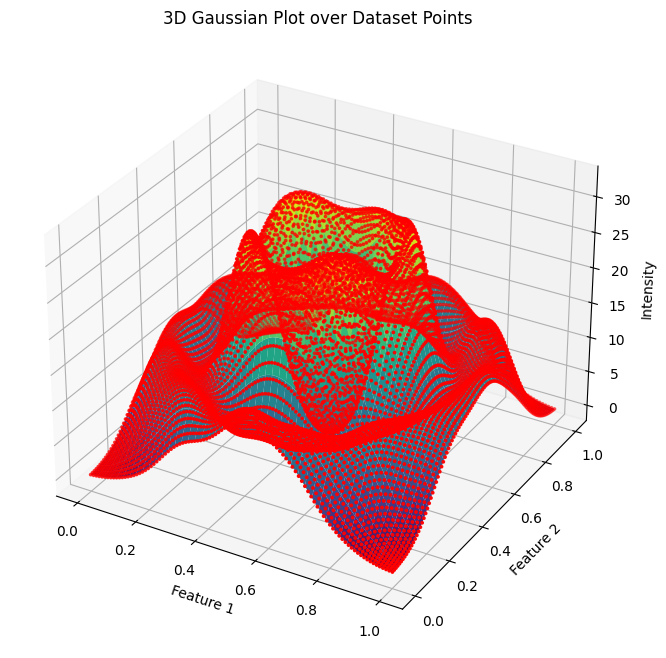

In [6]:
X = data

s = 0.07
# Function to generate a Gaussian peak at each data point

# Meshgrid for evaluation
grid = 400
x = np.linspace(0, 1, grid+1)
y = np.linspace(0, 1, grid+1)
x, y = np.meshgrid(x, y)

# Compute the sum of Gaussians at each grid point
z = np.zeros_like(x)
for point in X:
    z += gaussian(x, y, point[0], point[1], s)

# 3D plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, cmap='viridis', edgecolor='none')
ax.set_title('3D Gaussian Plot over Dataset Points')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Intensity')


# add ball
ball = 100
ball_x = np.linspace(0, 1, ball+1)
ball_y = np.linspace(0, 1, ball+1)
ball_x, ball_y = np.meshgrid(ball_x, ball_y)

ball_z = np.array([[z[i][j] for j in np.arange(0, 400+400//ball, 400//ball)] for i in np.arange(0, 400+400//ball, 400//ball)])

ax.scatter3D(ball_x, ball_y, ball_z, c='r', s=3)

plt.show()

Text(0.5, 0, 'Intensity')

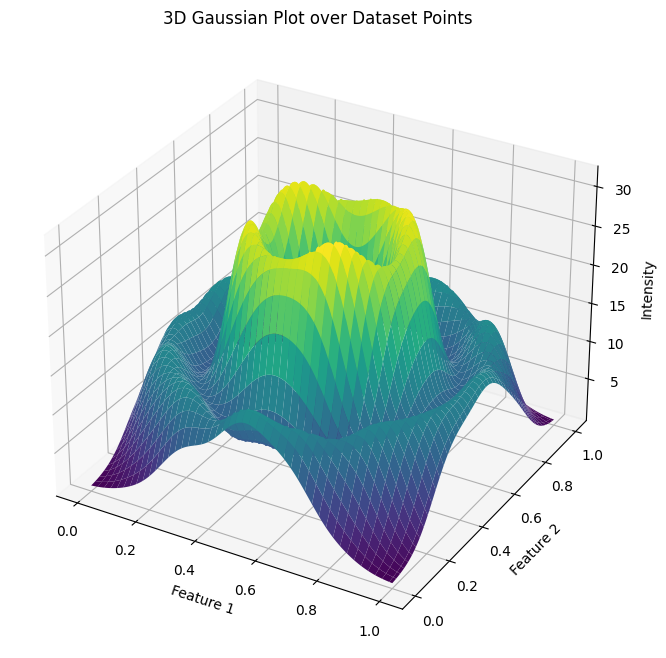

In [7]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, cmap='viridis', edgecolor='none')
ax.set_title('3D Gaussian Plot over Dataset Points')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Intensity')

In [125]:
bin_array = []

In [11]:
def gen_simul(data, lim, grid, ball, sigma, gen_num, k=2):
    global bin_array, edge, clusters_array
    X = data
    xlim, ylim = lim
    x = np.linspace(0, xlim, grid+1)
    y = np.linspace(0, ylim, grid+1)
    x, y = np.meshgrid(x, y)

    # Compute the sum of Gaussians at each grid point
    z = np.zeros_like(x)
    for point in X:
        z += gaussian(x, y, point[0], point[1], sigma=sigma)

    # add ball
    ball_x = np.linspace(0, xlim, ball+1)
    ball_y = np.linspace(0, ylim, ball+1)
    ball_x, ball_y = np.meshgrid(ball_x, ball_y)

    ball_z = np.array([[z[i][j] for j in np.arange(0, 400+400//ball, 400//ball)] for i in np.arange(0, 400+400//ball, 400//ball)])

    # iter
    delta = [[-1, 0], [1, 0], [0, -1], [0, 1]]

    level = np.zeros((ball+3, ball+3))
    level[1:ball+2, 1:ball+2] = ball_z.copy()

    level_bin = np.zeros((ball+3, ball+3))
    level_bin[1:ball+2, 1:ball+2] = np.ones((ball+1, ball+1))

    edge = np.zeros((ball+3, ball+3))

    temp_clusters = []

    clusters_array = [temp_clusters]
    level_array = [level.copy()]
    level_bin_array = [level_bin]
    edge_array = []

    gen = 1
    edge = []

    reach_to_k = 0

    f1 = 1
    f2 = 1

    # while gen < gen_num:
    while np.any(level_bin == 1):
        if f1:
            f1 = 0
        else:
            if not reach_to_k:
                clusters, k_ = label(level_bin[1:-1, 1:-1] == 0)
                if k_ <= k:
                    reach_to_k = 1

        if not reach_to_k:
            temp = level.copy()
            temp_bin = level_bin.copy()
            for i in range(1, ball+2):
                for j in range(1, ball+2):
                    if not temp_bin[i, j]: continue
                    flag = 1
                    for d in delta:
                        if level[i+d[0], j+d[1]] > level[i, j]:  # 부등호에서 등호 삭제(edge 처리 문제)
                            flag = 0
                            break
                    if flag:
                        temp[i, j] = 0
                        temp_bin[i, j] = 0
        else:
            if f2:
                f2 = 0
                pad = np.zeros((ball+3, ball+3))
                pad[1:-1, 1:-1] = clusters
                clusters = pad.copy()
                clusters = clusters.astype(np.uint8)
            temp = level.copy()
            temp_bin = level_bin.copy()
            temp_clusters = clusters.copy()
            for i in range(1, ball+2):
                for j in range(1, ball+2):
                    if not temp_bin[i, j]: continue
                    flag = 1
                    for d in delta:
                        if level[i+d[0], j+d[1]] > level[i, j]:  # 부등호에서 등호 삭제(edge 처리 문제)
                            flag = 0
                            break
                    if flag:
                        types = []
                        for d in delta:
                            if 0<i+d[0] and i+d[0]<ball+2 and 0<j+d[1] and j+d[1]<ball+2:
                                if temp_bin[i+d[0], j+d[1]] == 0:
                                    types.append(temp_clusters[i+d[0], j+d[1]])
                        if 0 in types: types.remove(0)
                        if len(set(types)) > 1:
                            edge.append([i, j])
                        temp[i, j] = 0
                        temp_bin[i, j] = 0
                        temp_clusters[i, j] = 0 if not types else types[0]

        gen += 1
        level_array.append(temp)
        level_bin_array.append(temp_bin)
        clusters_array.append(temp_clusters)

        level = temp
        level_bin = temp_bin
        clusters = temp_clusters

    bin_array = level_bin.copy()

    plot_level(level_bin_array, size1=2)

def plot_level(level_bin_array, size1 = 2):
    gen_num = len(level_bin_array)
    rows = gen_num//10 + 1
    plt.figure(figsize=(size1*10, size1*rows))

    for i in range(len(level_bin_array)):
        plt.subplot(rows, 10, i+1)
        plt.title(f"gen : {i}")
        plt.axis("off")
        plt.imshow(level_bin_array[i][::-1], cmap='gray')

    plt.show()

In [16]:
level_bin_array, edge = simul_edge(data, lim=(1, 1), grid=400, ball=100, sigma=0.07, k=2)

[[15, 51], [15, 50], [15, 52], [15, 49], [15, 53], [15, 48], [15, 54], [15, 47], [15, 55], [15, 46], [15, 56], [68, 19], [15, 45], [65, 17], [66, 18], [69, 19], [86, 39], [15, 44], [64, 17], [67, 18], [70, 19], [71, 84], [72, 83], [73, 82], [84, 36], [85, 37], [86, 40], [63, 17], [64, 88], [70, 84], [74, 82], [83, 34], [84, 35], [85, 38], [62, 17], [70, 85], [71, 20], [82, 32], [83, 33], [87, 41], [46, 88], [47, 89], [61, 17], [69, 85], [72, 20], [75, 81], [82, 31], [87, 42], [45, 88], [48, 89], [60, 17], [68, 85], [78, 26], [79, 27], [80, 28], [81, 29], [86, 62], [87, 43], [87, 61], [44, 88], [49, 89], [59, 17], [68, 86], [73, 21], [76, 80], [81, 30], [86, 63], [87, 60], [42, 87], [43, 88], [50, 89], [58, 17], [67, 86], [86, 64], [87, 59], [88, 44], [17, 67], [41, 87], [51, 89], [57, 17], [67, 87], [74, 22], [77, 79], [86, 65], [88, 45], [17, 66], [18, 69], [21, 30], [40, 87], [52, 89], [56, 17], [66, 87], [75, 22], [78, 79], [85, 65], [88, 46], [88, 58], [16, 64], [17, 65], [18, 68],

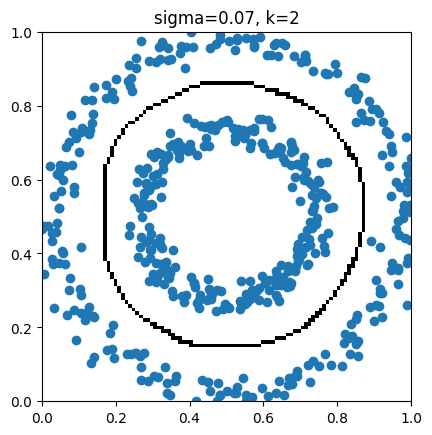

In [23]:
edge_array = [[1 for _ in range(103)] for _ in range(103)]
print(edge)
for i, j in edge:
    edge_array[i][j] = 0
edge_array = np.array(edge_array)
data = np.array(data)
plt.imshow(~edge_array[::-1], cmap='binary', extent=[0, 1, 0, 1])
plt.scatter(data[:, 0], data[:, 1])
plt.title("sigma=0.07, k=2")
plt.show()

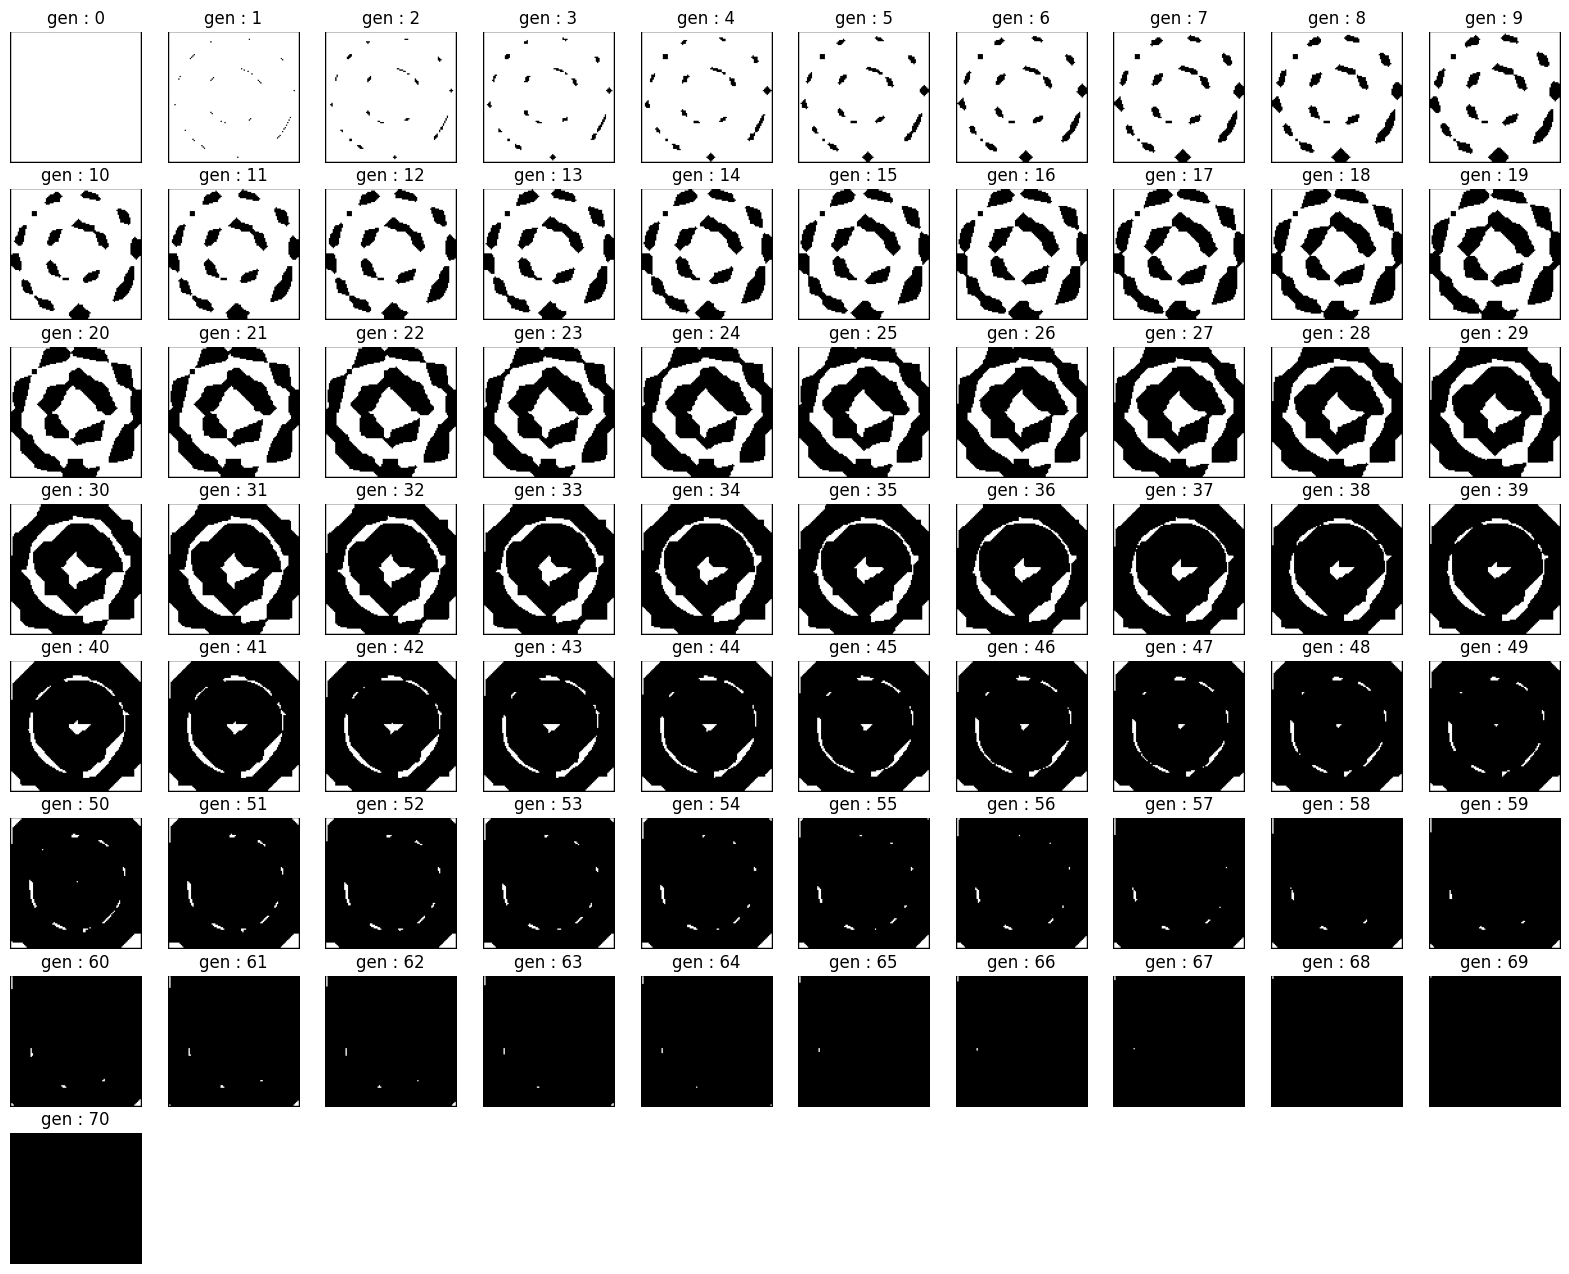

In [17]:
plot_level(level_bin_array, size1=2)

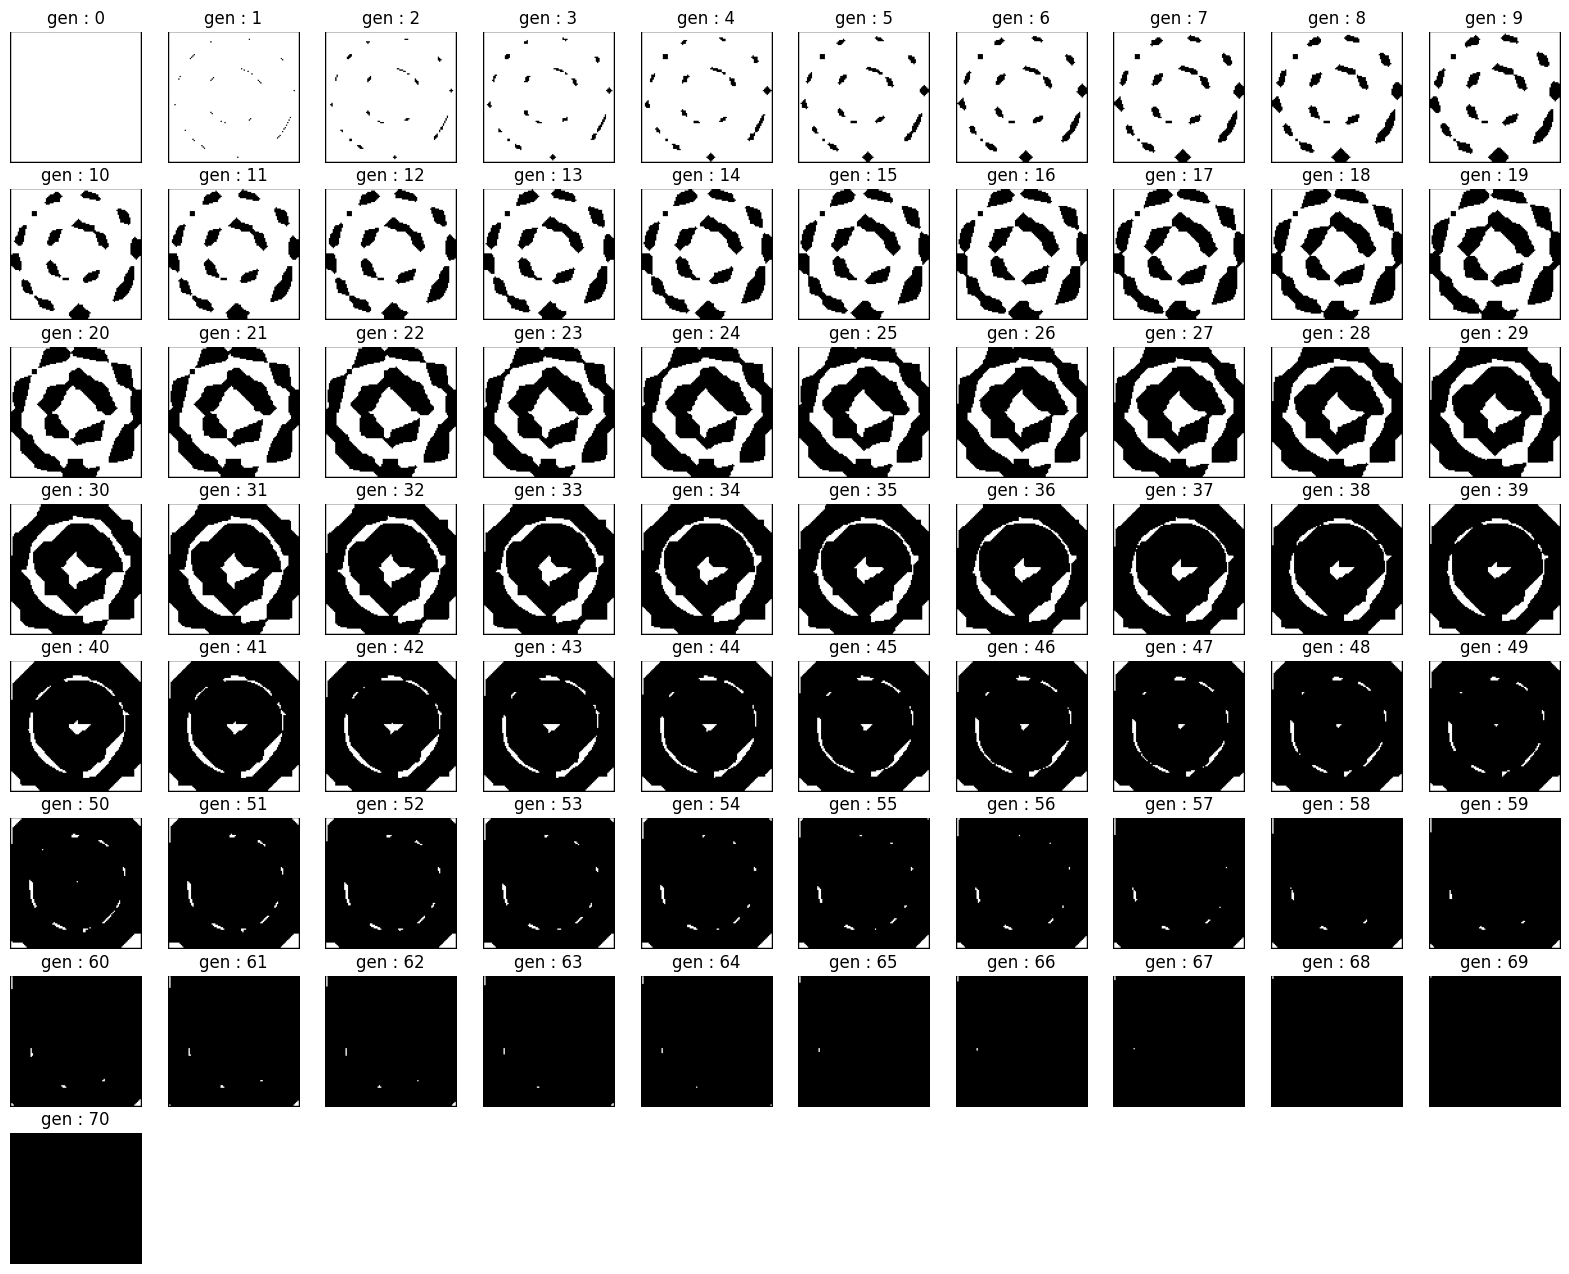

In [13]:
gen_simul(data=data, lim=(1, 1), grid=400, ball=100, sigma=0.07, gen_num=50, k=2)

In [119]:
len(edge)

289

In [120]:
edge_array = [[1 for _ in range(103)] for _ in range(103)]
for i, j in edge:
    edge_array[i][j] = 0
edge_array = np.array(edge_array)
edge_array.sum()

10320

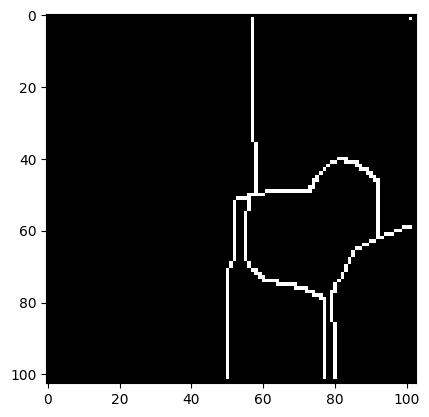

In [122]:
# edge_ar = np.array(edge)
plt.imshow(edge_array[::-1], cmap="binary")

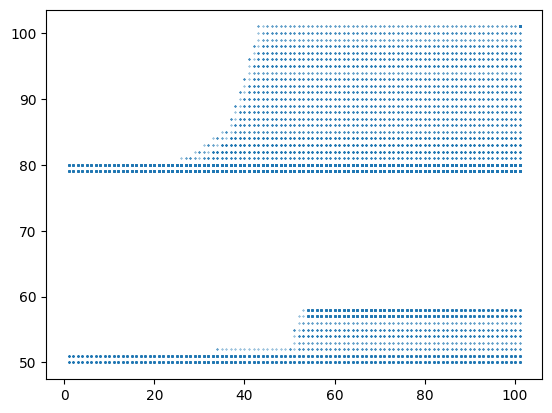

In [100]:
edge_ar = np.array(edge)
plt.scatter(edge_ar[:, 0], edge_ar[:, 1], s=0.1)

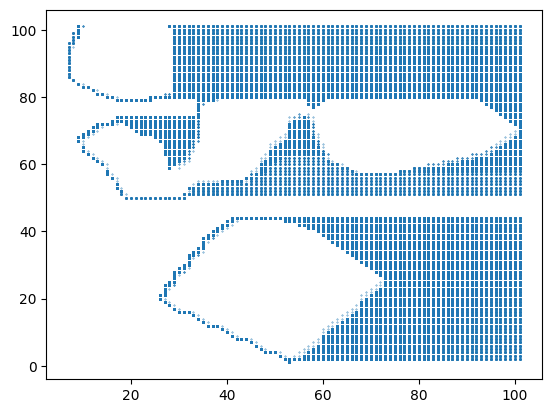

In [81]:
edge_ar = np.array(edge)
plt.scatter(edge_ar[:, 0], edge_ar[:, 1], s=0.1)

In [60]:
gen_simul(data=data, lim=(1, 1), grid=400, ball=100, sigma=0.1, gen_num=50)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\User\AppData\Local\Temp\ipykernel_6016\162453422.py", line 1, in <cell line: 1>
    gen_simul(data=data, lim=(1, 1), grid=400, ball=100, sigma=0.1, gen_num=50)
  File "C:\Users\User\AppData\Local\Temp\ipykernel_6016\1723326134.py", line -1, in gen_simul
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 1993, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\ultratb.py", line 1118, in structured_traceback
    return FormattedTB.structured_traceback(

In [12]:
bin_array = bin_array[1:-1, 1:-1]
bin_array

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

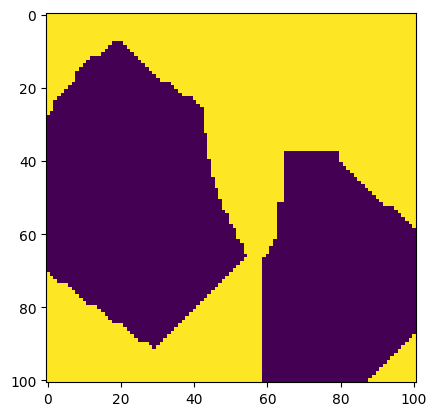

In [13]:
plt.imshow(bin_array)

In [14]:
bin_array.shape

(101, 101)

In [15]:
# 예시 2D 배열 (이미 0과 1로 구성됨)
array = bin_array

# 연결 성분 라벨링
labeled_array, num_features = label(array == 0)
print(labeled_array, num_features)

# 각 클러스터의 좌표 추출
clusters = [np.argwhere(labeled_array == i) for i in range(1, num_features + 1)]

# 데이터를 준비
X = np.vstack(clusters)
y = np.hstack([np.full(len(cluster), i) for i, cluster in enumerate(clusters)])
y = y.astype(np.float64)

if len(np.unique(y)) <= 1:
    raise ValueError("클러스터의 개수가 1개 이하입니다. 데이터를 확인하세요.")

# SVM을 사용하여 클러스터 간 경계선을 생성
svm = SVC(kernel='rbf', C=1, gamma='auto')
svm.fit(X, y)

# 경계선을 그리기 위한 그리드 생성
h = .02  # 그리드의 밀도
x_min, x_max = X[:, 1].min() - 1, X[:, 1].max() + 1
y_min, y_max = X[:, 0].min() - 1, X[:, 0].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# 예측
Z = svm.predict(np.c_[yy.ravel(), xx.ravel()])
Z = Z.reshape(xx.shape)

# 결과 시각화
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
colors = ['red', 'green', 'blue', 'purple', 'orange', 'cyan', 'magenta']

# 각 클러스터 시각화
for i, cluster in enumerate(clusters):
    plt.scatter(cluster[:, 1], cluster[:, 0], c=colors[i % len(colors)], label=f'Cluster {i + 1}')

plt.legend()
plt.title('Cluster Boundaries')
plt.show()


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] 2


In [16]:
plt.imshow(array)

NameError: name 'array' is not defined

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label
from sklearn.svm import SVC

# 예시 2D 배열 (이미 0과 1로 구성됨)
# array = np.array([
#     [0, 0, 0, 1, 1, 1, 0, 0, 0],
#     [0, 1, 1, 1, 1, 1, 1, 1, 0],
#     [0, 1, 0, 0, 1, 0, 0, 1, 0],
#     [1, 1, 0, 0, 0, 0, 0, 1, 1],
#     [1, 1, 1, 0, 0, 0, 1, 1, 1],
#     [1, 1, 0, 0, 0, 0, 0, 1, 1],
#     [0, 1, 0, 0, 1, 0, 0, 1, 0],
#     [0, 1, 1, 1, 1, 1, 1, 1, 0],
#     [0, 0, 0, 1, 1, 1, 0, 0, 0]
# ])

array = bin_array

# 연결 성분 라벨링
labeled_array, num_features = label(array == 0)

print(labeled_array, num_features)

# 각 클러스터의 좌표 추출
clusters = [np.argwhere(labeled_array == i) for i in range(1, num_features + 1)]

# 데이터를 준비
X = np.vstack(clusters)
y = np.hstack([np.full(len(cluster), i) for i, cluster in enumerate(clusters)])

# 클러스터가 두 개 이상인지 확인
if len(np.unique(y)) <= 1:
    raise ValueError("클러스터의 개수가 1개 이하입니다. 데이터를 확인하세요.")

# SVM을 사용하여 클러스터 간 경계선을 생성
svm = SVC(kernel='rbf', C=1, gamma='auto')
svm.fit(X, y)

# 경계선을 그리기 위한 그리드 생성
h = .02  # 그리드의 밀도
x_min, x_max = X[:, 1].min() - 1, X[:, 1].max() + 1
y_min, y_max = X[:, 0].min() - 1, X[:, 0].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# 예측
Z = svm.predict(np.c_[yy.ravel(), xx.ravel()])
Z = Z.reshape(xx.shape)

# 결과 시각화
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
colors = ['red', 'green', 'blue', 'purple', 'orange', 'cyan', 'magenta']

# 각 클러스터 시각화
for i, cluster in enumerate(clusters):
    plt.scatter(cluster[:, 1], cluster[:, 0], c=colors[i % len(colors)], label=f'Cluster {i + 1}')

plt.legend()
plt.title('Cluster Boundaries')
plt.show()


[[1 1 1 ... 1 1 1]
 [1 0 0 ... 0 0 1]
 [1 0 0 ... 0 0 1]
 ...
 [1 0 0 ... 0 0 1]
 [1 0 0 ... 0 0 1]
 [1 1 1 ... 1 1 1]] 1


ValueError: 클러스터의 개수가 1개 이하입니다. 데이터를 확인하세요.